In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter
from scipy import interpolate


import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


In [3]:
ds_MPIhist = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001-201412.nc')
ds_MPI245 = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_201501-210012.nc')
ds_MPI585 = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_201501-210012.nc')

ds_MPI245

<xarray.Dataset>
Dimensions:    (time: 1032, bnds: 2, lat: 192, lon: 384)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by DKRZ is licensed und...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/5d919613-fddc-429a-a6eb-e7b4cb90eaeb
    NCO:                    netCDF Operators version 5.2.4 (Homepage = http:/...

In [4]:
ds_MPI245.tas

<xarray.DataArray 'tas' (time: 1032, lat: 192, lon: 384)>
[76087296 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    height   float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-07-15T20:20:00Z altered by CMOR: Treated scalar dime...

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


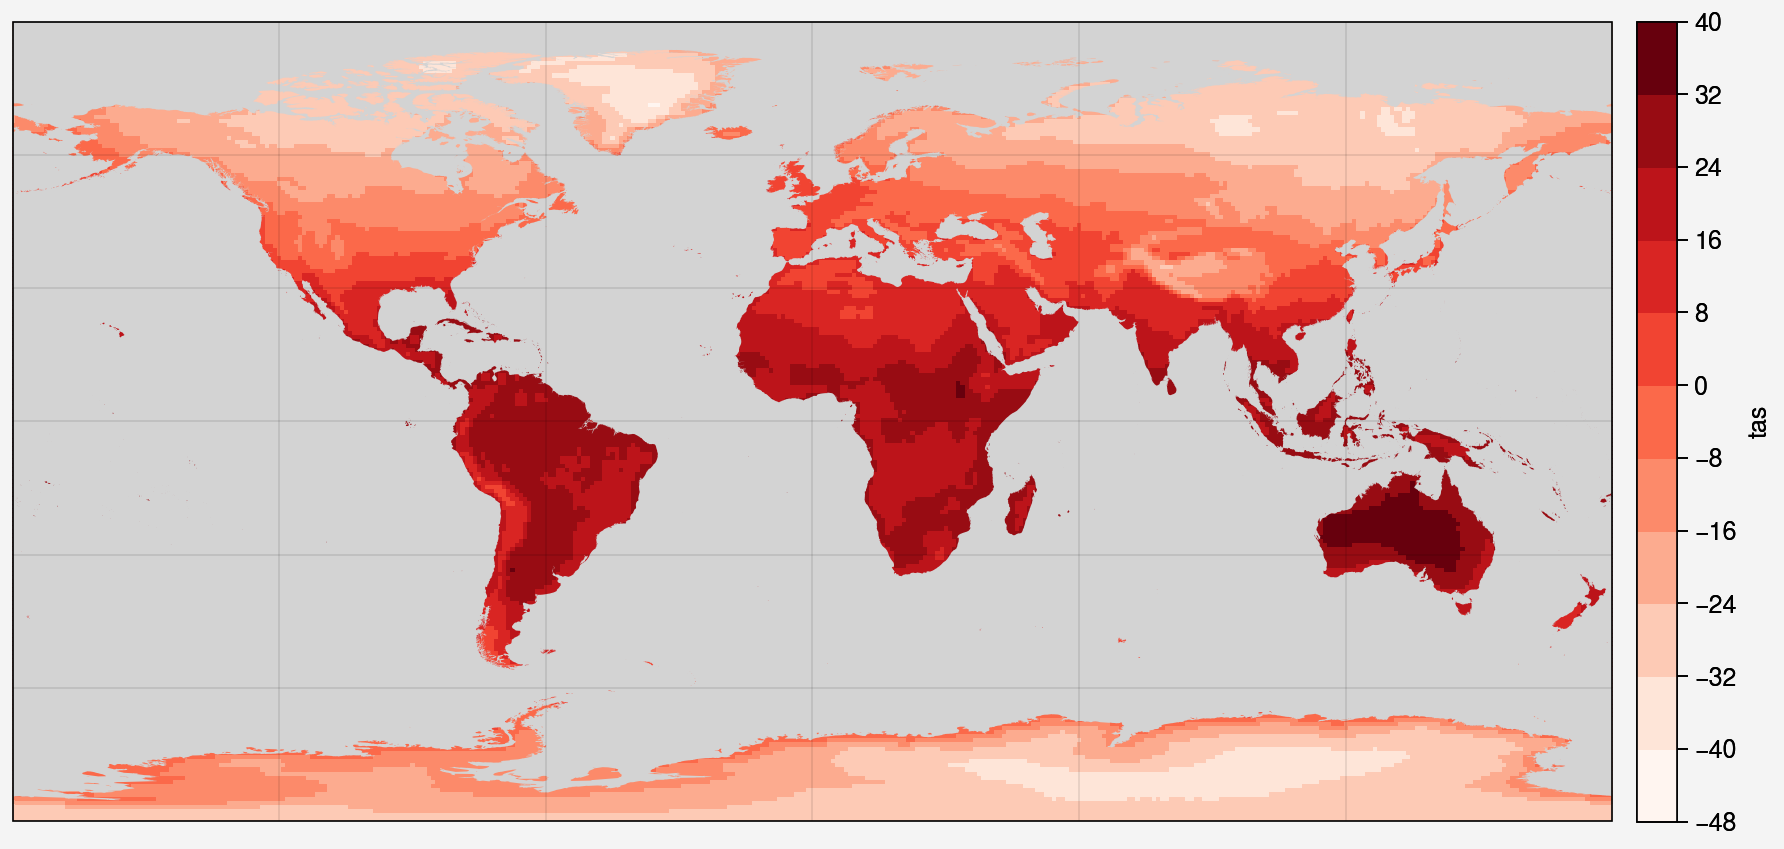

In [5]:
f, axs = pplt.subplots(proj='cyl', axwidth=8)

m=axs.pcolormesh(ds_MPI245.lon, ds_MPI245.lat, ds_MPI245.tas[0]-273.16, levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')

#axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


In [6]:
#ds_MPI245_tas = ds_MPI245.tas-273.16

yrly_tas_MPI245_globalmean = u.spatial_average(ds_MPI245.tas.groupby("time.year").mean("time")) - 273.16
yrly_tas_MPI245_globalmean

<xarray.DataArray (year: 86)>
array([14.88136813, 14.87146925, 14.9143175 , 15.06898105, 15.24614349,
       15.15010217, 15.20402204, 15.21841472, 15.14092828, 15.26612497,
       15.21639498, 15.04730113, 15.15430049, 15.1802172 , 15.39071091,
       15.26188581, 15.20724498, 15.37327021, 15.38036038, 15.46899238,
       15.44596824, 15.31848545, 15.41148873, 15.41782051, 15.32842431,
       15.51145025, 15.53697164, 15.51561829, 15.34408925, 15.44063787,
       15.52783794, 15.70095377, 15.79860556, 15.76339348, 15.69228191,
       15.7578959 , 15.91069935, 15.91404331, 15.73488633, 15.6883603 ,
       15.64101624, 15.59885665, 15.7405212 , 15.95369661, 16.00699361,
       15.8714711 , 15.73232512, 15.74808414, 16.00375037, 15.98354536,
       15.95397885, 16.16556404, 15.96834321, 15.88857934, 15.91301273,
       16.10115394, 16.12965506, 16.12226165, 16.21893595, 16.29073987,
       16.24006695, 16.31165472, 16.17943775, 16.15119256, 16.09455358,
       16.2329253 , 16.26936489, 16.20453314, 16.27874751, 16.26525691,
       16.2681783 , 16.36043953, 16.30476197, 16.3407745 , 16.36186455,
       16.38927164, 16.30054974, 16.26602452, 16.42618118, 16.40750181,
       16.32806404, 16.4065584 , 16.42741611, 16.3040506 , 16.22545949,
       16.3740398 ])
Coordinates:
    height   float64 2.0
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [7]:
yrly_tas_MPI585_globalmean = u.spatial_average(ds_MPI585.tas.groupby("time.year").mean("time")) - 273.16
yrly_tas_MPI585_globalmean

<xarray.DataArray (year: 86)>
array([14.8956645 , 14.99628039, 15.0167827 , 15.13492552, 15.15499785,
       15.17376928, 15.11323173, 15.20491675, 15.14519596, 15.16140647,
       15.16603915, 15.18715652, 15.2277091 , 15.17741903, 15.32665294,
       15.44375674, 15.5691803 , 15.35718641, 15.3183718 , 15.43676136,
       15.59685415, 15.55298482, 15.49538946, 15.67692233, 15.55462757,
       15.57872053, 15.52836279, 15.71886348, 15.8426865 , 15.6925802 ,
       15.68237476, 15.62466793, 15.63320755, 15.91385933, 16.10500779,
       16.00869971, 15.9283305 , 15.90160535, 16.07157663, 16.25270994,
       16.15910884, 16.21033403, 16.33341455, 16.34388217, 16.20583202,
       16.35881691, 16.54029969, 16.39096813, 16.51106834, 16.41634266,
       16.67039296, 16.55767819, 16.51197838, 16.59839348, 16.76310869,
       16.88394465, 16.79077004, 16.79241207, 17.0320049 , 16.98787649,
       16.88630368, 17.00061679, 16.99084446, 16.97092215, 17.23188422,
       17.27291439, 17.29116894, 17.32663141, 17.58787818, 17.44130851,
       17.42504252, 17.38567292, 17.5884896 , 17.68794559, 17.69040354,
       17.82572528, 18.05577033, 17.97225851, 18.00251693, 18.04600001,
       18.10001751, 18.19950195, 18.19946564, 18.27784804, 18.29822972,
       18.21565368])
Coordinates:
    height   float64 2.0
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [8]:
yrly_tas_MPIhist_globalmean = u.spatial_average(ds_MPIhist.tas.groupby("time.year").mean("time")) - 273.16

In [9]:
#del ds_MPIhist,ds_MPI245,ds_MPI585


In [ ]:
# DJF_tas_MPI245 = u.spatial_average(ds_MPI245.tas.sel(time=ds_MPI245.tas.time.dt.season=="DJF").groupby("time.year").mean("time")) - 273.16
# MAM_tas_MPI245 = u.spatial_average(ds_MPI245.tas.sel(time=ds_MPI245.tas.time.dt.season=="MAM").groupby("time.year").mean("time")) - 273.16
# JJA_tas_MPI245 = u.spatial_average(ds_MPI245.tas.sel(time=ds_MPI245.tas.time.dt.season=="JJA").groupby("time.year").mean("time")) - 273.16
# SON_tas_MPI245 = u.spatial_average(ds_MPI245.tas.sel(time=ds_MPI245.tas.time.dt.season=="SON").groupby("time.year").mean("time")) - 273.16

# allseas_tas_MPI245 = [DJF_tas_MPI245,MAM_tas_MPI245,JJA_tas_MPI245,SON_tas_MPI245]

# DJF_tas_MPI585 = u.spatial_average(ds_MPI585.tas.sel(time=ds_MPI585.tas.time.dt.season=="DJF").groupby("time.year").mean("time")) - 273.16
# MAM_tas_MPI585 = u.spatial_average(ds_MPI585.tas.sel(time=ds_MPI585.tas.time.dt.season=="MAM").groupby("time.year").mean("time")) - 273.16
# JJA_tas_MPI585 = u.spatial_average(ds_MPI585.tas.sel(time=ds_MPI585.tas.time.dt.season=="JJA").groupby("time.year").mean("time")) - 273.16
# SON_tas_MPI585 = u.spatial_average(ds_MPI585.tas.sel(time=ds_MPI585.tas.time.dt.season=="SON").groupby("time.year").mean("time")) - 273.16

# allseas_tas_MPI585 = [DJF_tas_MPI585,MAM_tas_MPI585,JJA_tas_MPI585,SON_tas_MPI585]
# DJF_tas_MPIhist = u.spatial_average(ds_MPIhist.tas.sel(time=ds_MPIhist.tas.time.dt.season=="DJF").groupby("time.year").mean("time")) - 273.16
# MAM_tas_MPIhist = u.spatial_average(ds_MPIhist.tas.sel(time=ds_MPIhist.tas.time.dt.season=="MAM").groupby("time.year").mean("time")) - 273.16
# JJA_tas_MPIhist = u.spatial_average(ds_MPIhist.tas.sel(time=ds_MPIhist.tas.time.dt.season=="JJA").groupby("time.year").mean("time")) - 273.16
# SON_tas_MPIhist = u.spatial_average(ds_MPIhist.tas.sel(time=ds_MPIhist.tas.time.dt.season=="SON").groupby("time.year").mean("time")) - 273.16

# allseas_tas_MPIhist = [DJF_tas_MPIhist,MAM_tas_MPIhist,JJA_tas_MPIhist,SON_tas_MPIhist]

# np.save('/bettik/castelli/data/MPI-ESM1-2-HR/allseas_tas_MPI_hist.npy', allseas_tas_MPIhist)
# np.save('/bettik/castelli/data/MPI-ESM1-2-HR/allseas_tas_MPI_245.npy', allseas_tas_MPI245)
# np.save('/bettik/castelli/data/MPI-ESM1-2-HR/allseas_tas_MPI_585.npy', allseas_tas_MPI585)

# DJF_tas_MPI245

In [11]:
allseas_tas_MPIhist = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/allseas_tas_MPI_hist.npy')
allseas_tas_MPI245 = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/allseas_tas_MPI_245.npy')
allseas_tas_MPI585 = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/allseas_tas_MPI_585.npy')

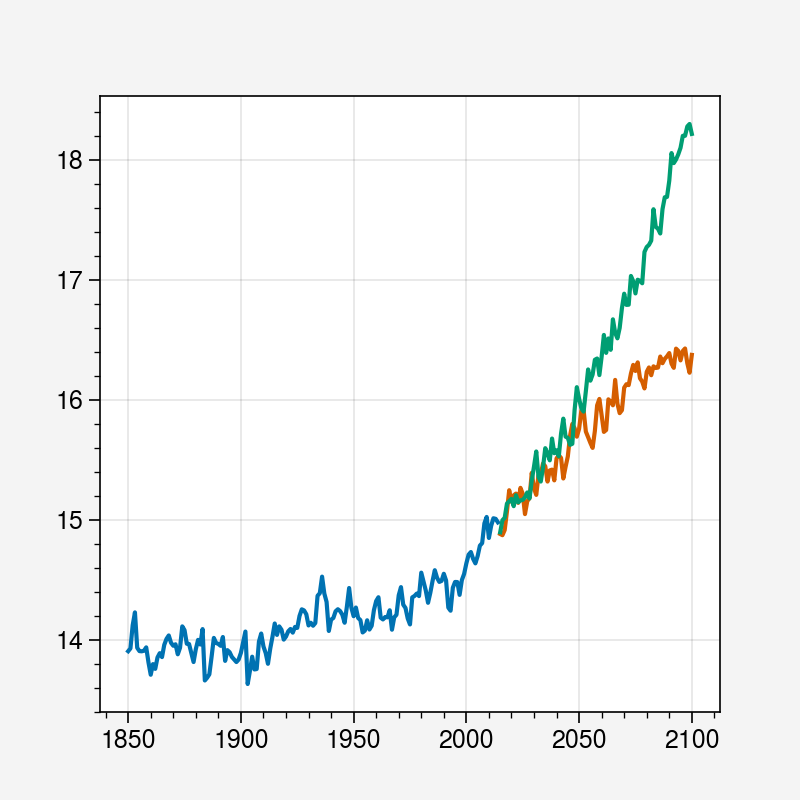

In [12]:
plt.plot(np.arange(1850,2015,1),yrly_tas_MPIhist_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_MPI245_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_MPI585_globalmean)

In [13]:
#
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_hist.npy', yrly_tas_MPIhist_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp245.npy', yrly_tas_MPI245_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp585.npy', yrly_tas_MPI585_globalmean)

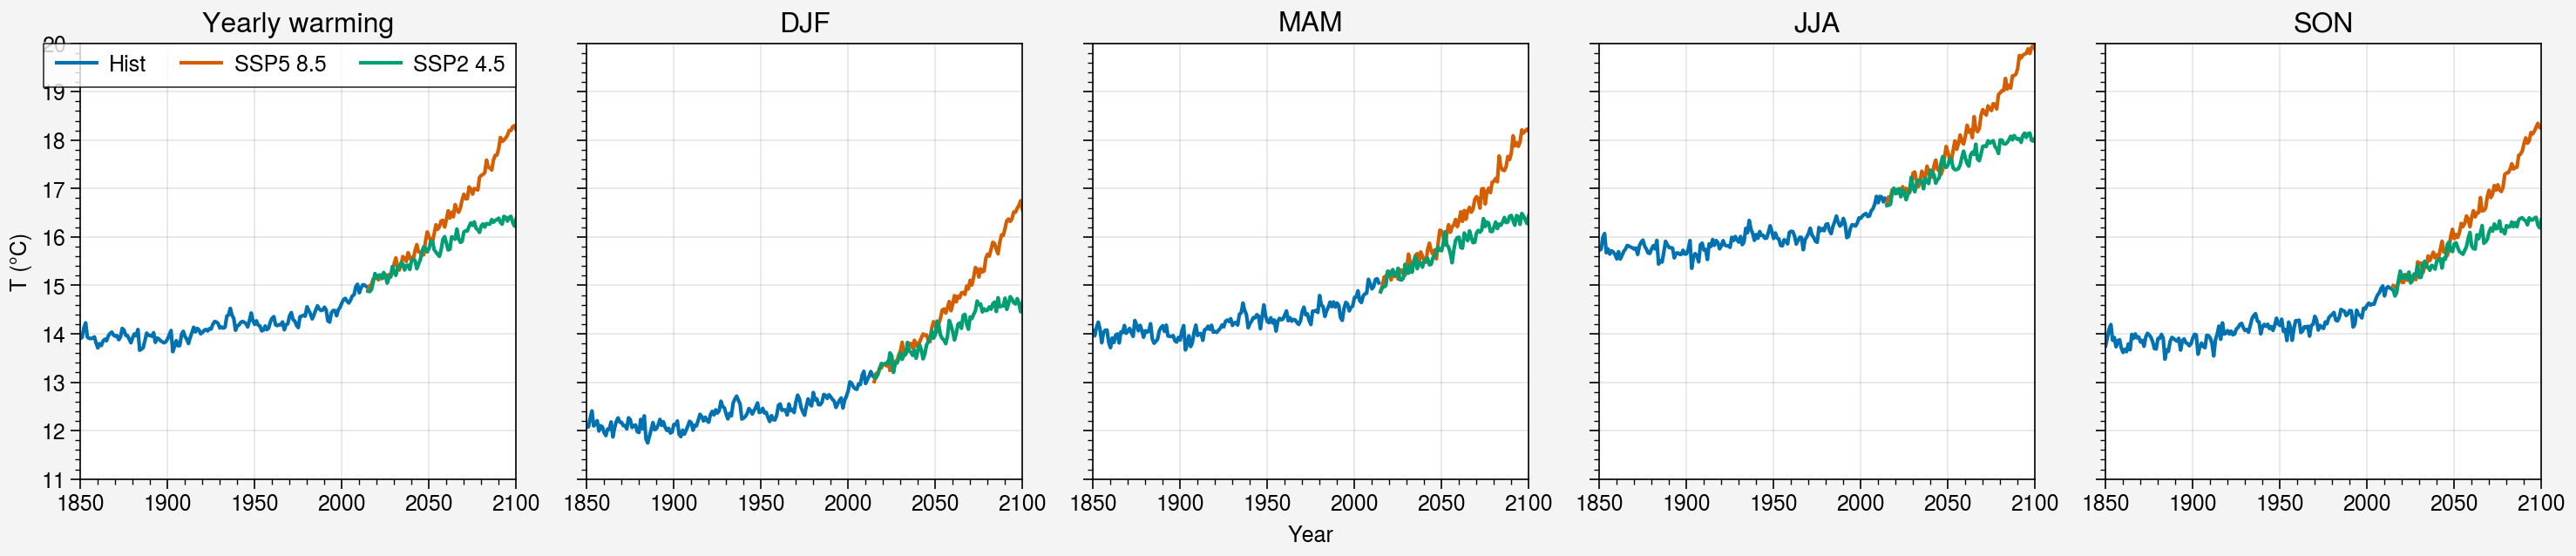

In [14]:
f,axs = pplt.subplots(ncols=5)

seasons = ['DJF','MAM','JJA', 'SON']

axs[0].plot(np.arange(1850,2015,1),yrly_tas_MPIhist_globalmean,label='Hist')
axs[0].plot(np.arange(2015,2101,1),yrly_tas_MPI585_globalmean,label='SSP5 8.5')
axs[0].plot(np.arange(2015,2101,1),yrly_tas_MPI245_globalmean,label='SSP2 4.5')


axs[0].format(title='Yearly warming')
axs[0].set_ylim((11.,20))

for i in range(4):
    ax=axs[i+1]
    ax.plot(np.arange(1850,2015,1),allseas_tas_MPIhist[i])
    ax.plot(np.arange(2015,2101,1),allseas_tas_MPI585[i])
    ax.plot(np.arange(2015,2101,1),allseas_tas_MPI245[i])
    
    ax.format(title=seasons[i])
    ax.set_ylim((11.,20))

axs[0].legend()
axs.format(ylabel='T (°C)',xlabel="Year",titlesize='16px')

## EC-Earth3

In [15]:
ds_ECEarth_hist = xr.open_dataset('/bettik/castelli/data/EC-Earth3/tas_Amon_EC-Earth3_hist_r25i1p1f1_gr_185001-201412.nc')
ds_ECEarth_245 = xr.open_dataset('/bettik/castelli/data/EC-Earth3/tas_Amon_EC-Earth3_ssp245_r25i1p1f1_gr_201501-210012.nc')

ds_ECEarth_245

<xarray.Dataset>
Dimensions:    (time: 1032, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP
    branch_time:               0.0
    contact:                   cmip6-data@ec-earth.org
    creation_date:             2019-11-16T07:53:16Z
    data_specs_version:        01.00.27
    ...                        ...
    parent_variant_label:      r1i1p1f1
    branch_method:             standard
    branch_time_in_parent:     60265.0
    branch_time_in_child:      60265.0
    nominal_resolution:        100 km
    history:                   Thu Feb 13 00:35:20 2020: ncatted -O -a calend...

In [ ]:
#ds_ECEarth_245_tas = ds_ECEarth_245.tas-273.16
#del ds_ECEarth_245

# yrly_tas_ECEarth_245_globalmean = u.spatial_average(ds_ECEarth_245.tas.groupby("time.year").mean("time")) - 273.16
# yrly_tas_ECEarth_hist_globalmean = u.spatial_average(ds_ECEarth_hist.tas.groupby("time.year").mean("time")) - 273.16

In [ ]:
# DJF_tas_ECEarth_245 = u.spatial_average(ds_ECEarth_245.tas.sel(time=ds_ECEarth_245.tas.time.dt.season=="DJF").groupby("time.year").mean("time")) - 273.16
# MAM_tas_ECEarth_245 = u.spatial_average(ds_ECEarth_245.tas.sel(time=ds_ECEarth_245.tas.time.dt.season=="MAM").groupby("time.year").mean("time")) - 273.16
# JJA_tas_ECEarth_245 = u.spatial_average(ds_ECEarth_245.tas.sel(time=ds_ECEarth_245.tas.time.dt.season=="JJA").groupby("time.year").mean("time")) - 273.16
# SON_tas_ECEarth_245 = u.spatial_average(ds_ECEarth_245.tas.sel(time=ds_ECEarth_245.tas.time.dt.season=="SON").groupby("time.year").mean("time")) - 273.16

# allseas_tas_ECEarth_245 = [DJF_tas_ECEarth_245,MAM_tas_ECEarth_245,JJA_tas_ECEarth_245,SON_tas_ECEarth_245]

# DJF_tas_ECEarth_hist = u.spatial_average(ds_ECEarth_hist.tas.sel(time=ds_ECEarth_hist.tas.time.dt.season=="DJF").groupby("time.year").mean("time")) - 273.16
# MAM_tas_ECEarth_hist = u.spatial_average(ds_ECEarth_hist.tas.sel(time=ds_ECEarth_hist.tas.time.dt.season=="MAM").groupby("time.year").mean("time")) - 273.16
# JJA_tas_ECEarth_hist = u.spatial_average(ds_ECEarth_hist.tas.sel(time=ds_ECEarth_hist.tas.time.dt.season=="JJA").groupby("time.year").mean("time")) - 273.16
# SON_tas_ECEarth_hist = u.spatial_average(ds_ECEarth_hist.tas.sel(time=ds_ECEarth_hist.tas.time.dt.season=="SON").groupby("time.year").mean("time")) - 273.16

# allseas_tas_ECEarth_hist = [DJF_tas_ECEarth_hist,MAM_tas_ECEarth_hist,JJA_tas_ECEarth_hist,SON_tas_ECEarth_hist]

# np.save('/bettik/castelli/data/EC-Earth3/allseas_tas_ECEarth_hist.npy', allseas_tas_ECEarth_hist)
# np.save('/bettik/castelli/data/EC-Earth3/allseas_tas_ECEarth_245.npy', allseas_tas_ECEarth_245)

In [16]:
#np.save('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_hist.npy', yrly_tas_ECEarth_hist_globalmean)
#np.save('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_ssp245.npy', yrly_tas_ECEarth_245_globalmean)


In [16]:
allseas_tas_ECEarth_hist = np.load('/bettik/castelli/data/EC-Earth3/allseas_tas_ECEarth_hist.npy')
allseas_tas_ECEarth_245 = np.load('/bettik/castelli/data/EC-Earth3/allseas_tas_ECEarth_245.npy')

yrly_tas_ECEarth_hist_globalmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_hist.npy')
yrly_tas_ECEarth_245_globalmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_ssp245.npy')

In [17]:
yrly_tas_MPIhist_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_hist.npy')
yrly_tas_MPI245_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp245.npy')
yrly_tas_MPI585_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp585.npy')

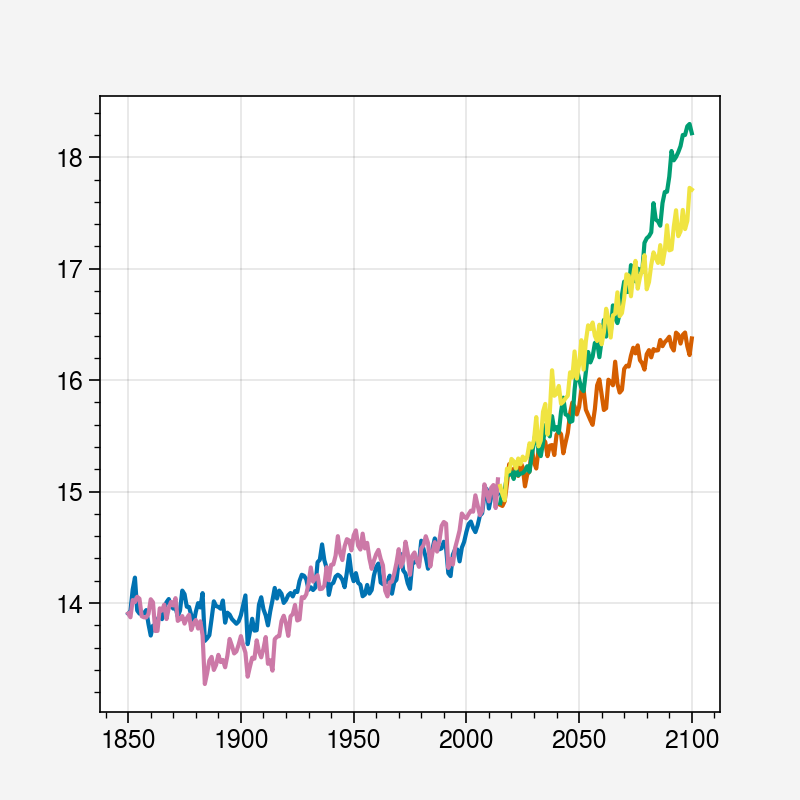

In [18]:
plt.plot(np.arange(1850,2015,1),yrly_tas_MPIhist_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_MPI245_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_MPI585_globalmean)

plt.plot(np.arange(1850,2015,1),yrly_tas_ECEarth_hist_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_ECEarth_245_globalmean)

## Warming splines

In [1]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t, c, k = interpolate.splrep(x, y, t=q_knots)
    print(k)
    yfit = interpolate.BSpline(t,c,k)(x)
    return yfit

In [20]:
yrly_tas_ECEarth_globalmean = np.concatenate([yrly_tas_ECEarth_hist_globalmean,yrly_tas_ECEarth_245_globalmean])
yrly_tas_MPI2_globalmean = np.concatenate([yrly_tas_MPIhist_globalmean,yrly_tas_MPI245_globalmean])
yrly_tas_MPI5_globalmean = np.concatenate([yrly_tas_MPIhist_globalmean,yrly_tas_MPI585_globalmean])

yrly_tas_ECEarth_globalmean.shape

(251,)

In [21]:
kn = 4
yfit = spline(kn,np.arange(1850,2101,1), yrly_tas_ECEarth_globalmean)

3


In [22]:
yrly_tas_ECEarth_hist_globalmean.shape

(165,)

3
3
3
3
3
3
3
3
3
3
3
3


Text(0.5, 0.98, 'MPI 585')

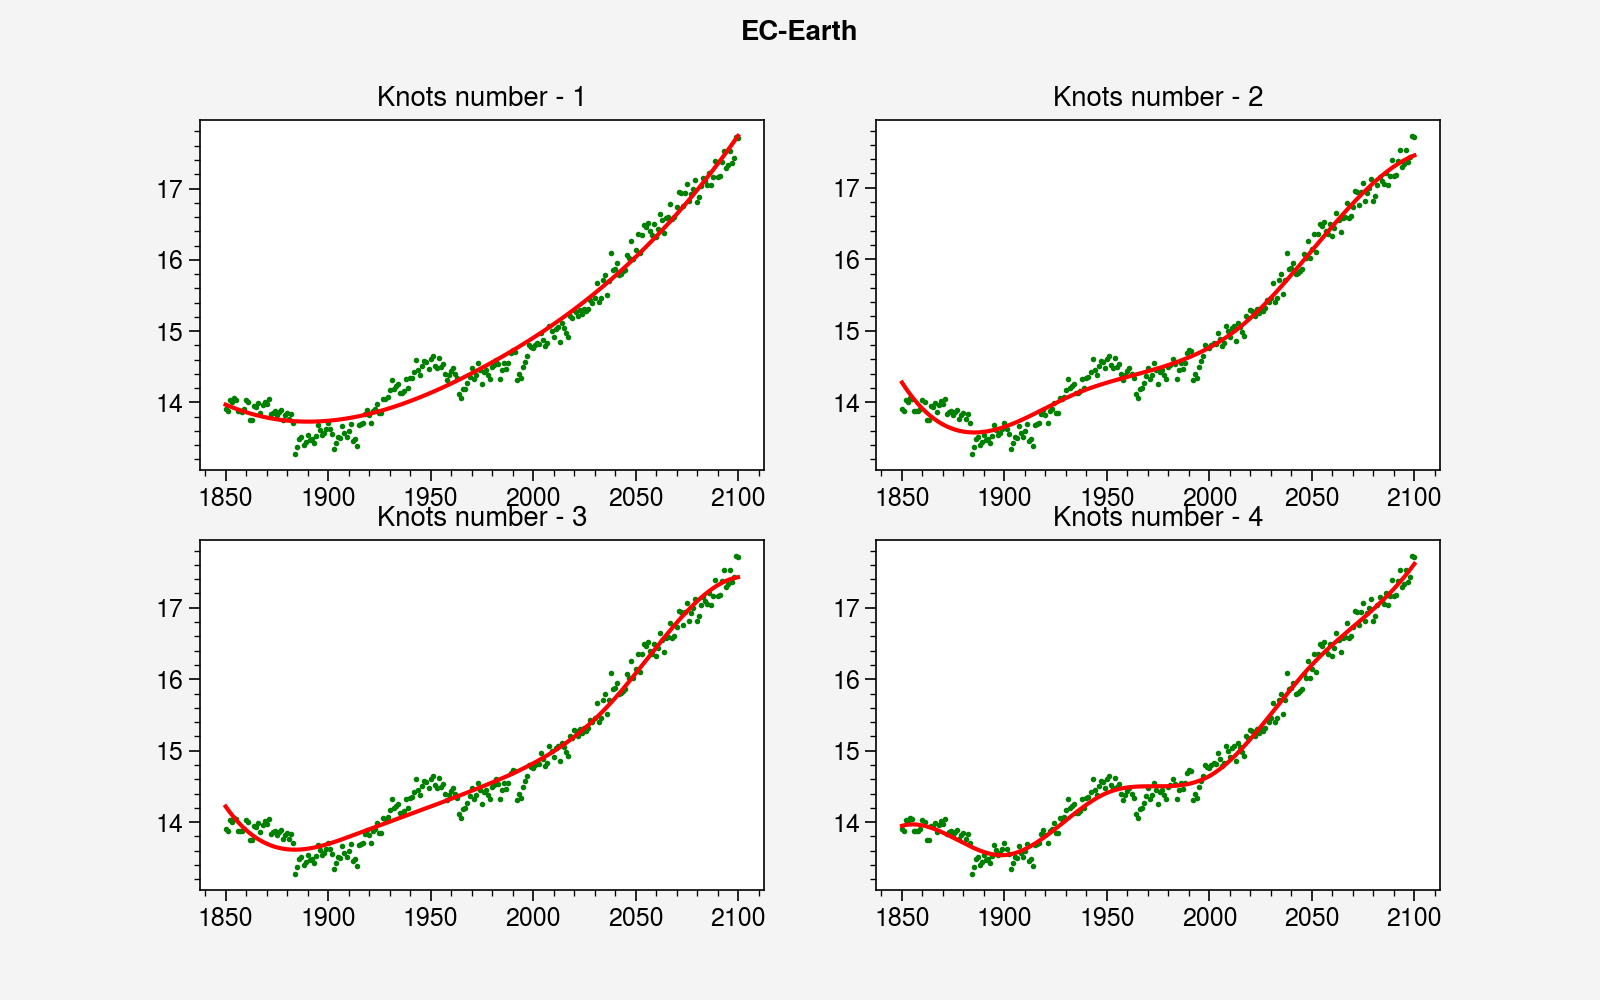

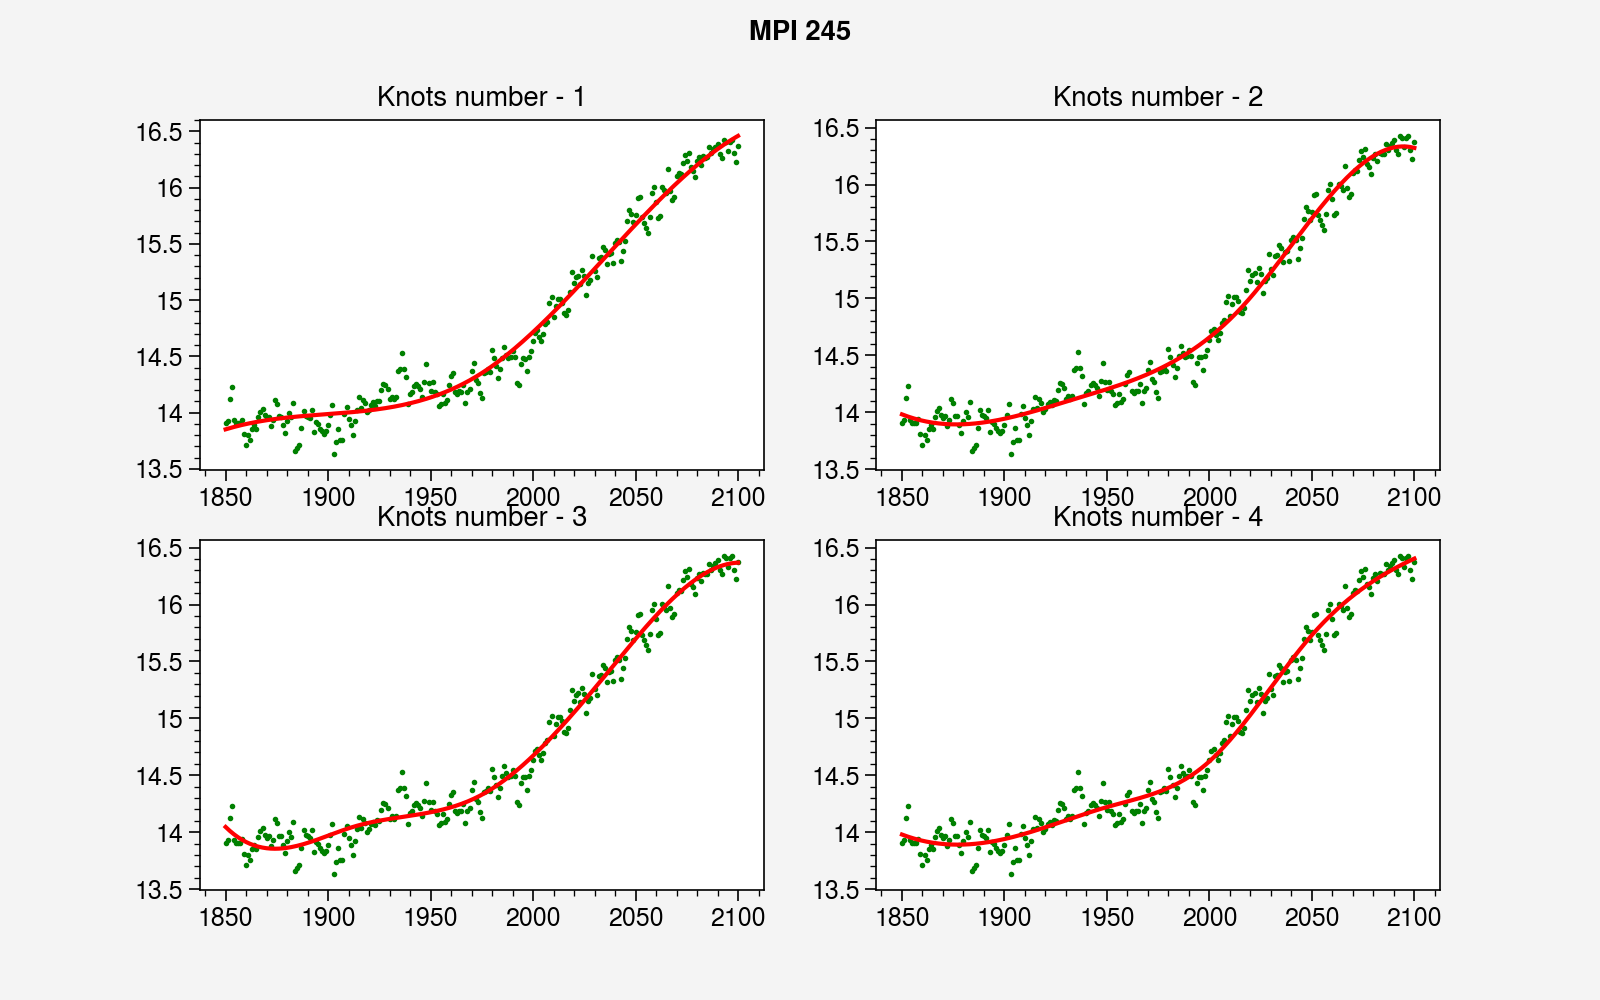

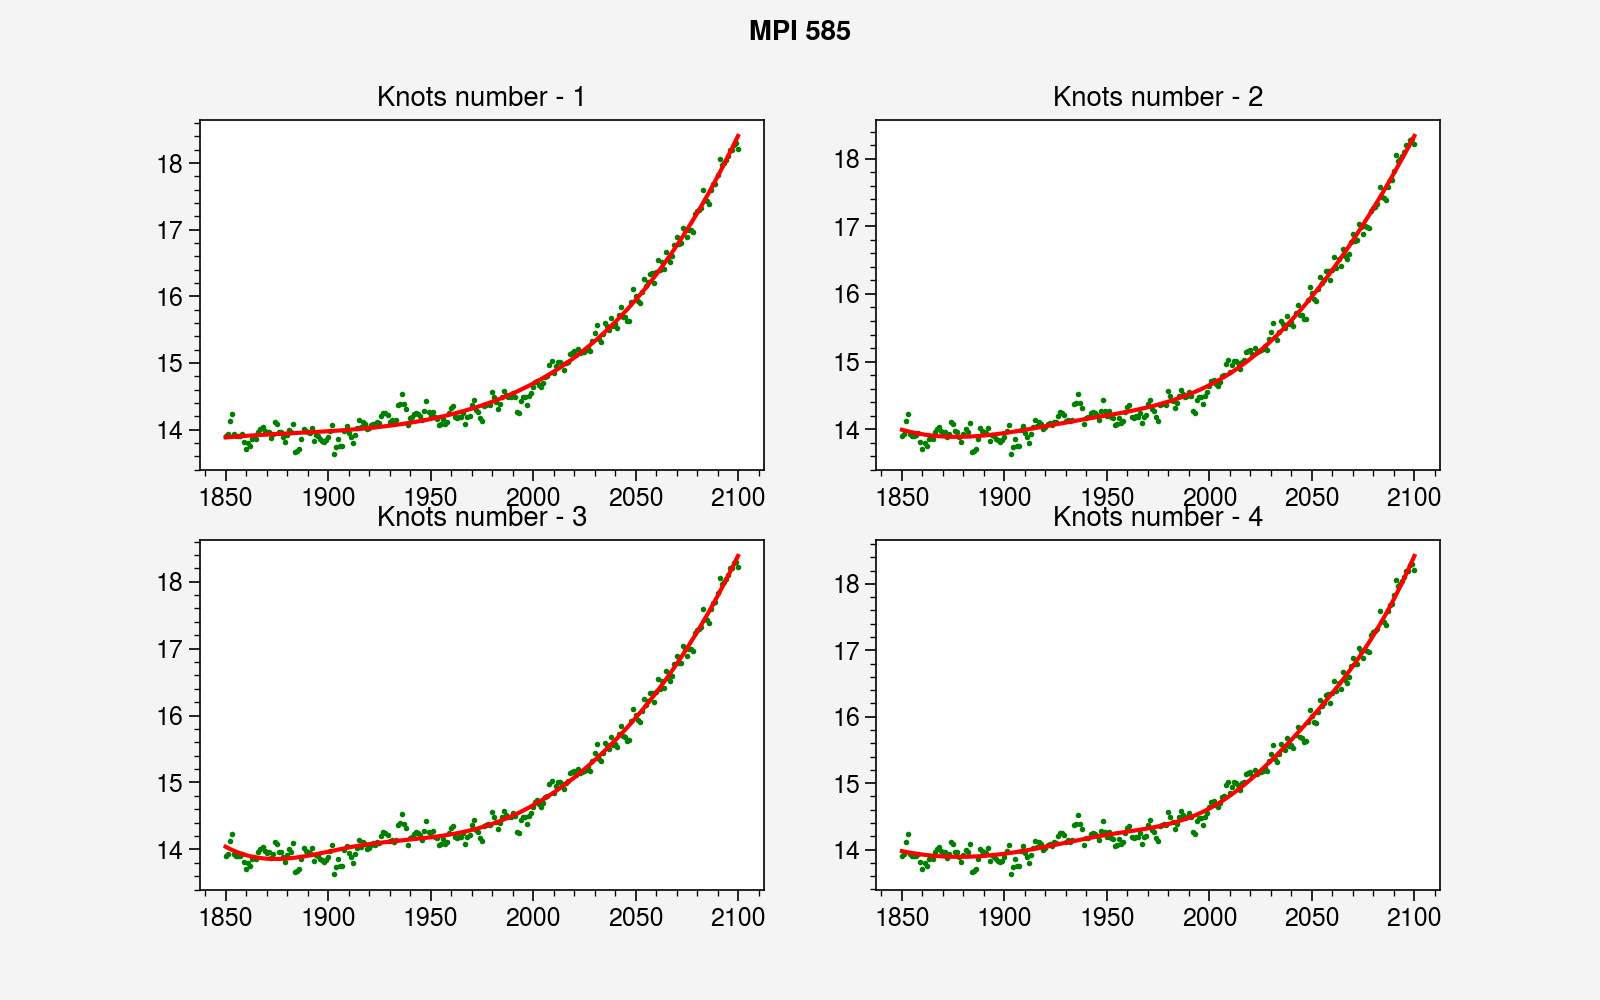

In [23]:
knots = [1, 2, 3, 4]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(np.arange(1850,2101,1), yrly_tas_ECEarth_globalmean, '.',c="g", markersize=2)
        yfit = spline(knots[i],np.arange(1850,2101,1), yrly_tas_ECEarth_globalmean)
        ax[row][col].plot(np.arange(1850,2101,1), yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
ig.suptitle('EC-Earth')

# ---------
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(np.arange(1850,2101,1), yrly_tas_MPI2_globalmean, '.',c="g", markersize=2)
        yfit = spline(knots[i],np.arange(1850,2101,1), yrly_tas_MPI2_globalmean)
        ax[row][col].plot(np.arange(1850,2101,1), yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
ig.suptitle('MPI 245')

# ---------
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(np.arange(1850,2101,1), yrly_tas_MPI5_globalmean, '.',c="g", markersize=2)
        yfit = spline(knots[i],np.arange(1850,2101,1), yrly_tas_MPI5_globalmean)
        ax[row][col].plot(np.arange(1850,2101,1), yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
ig.suptitle('MPI 585')

3
3
3


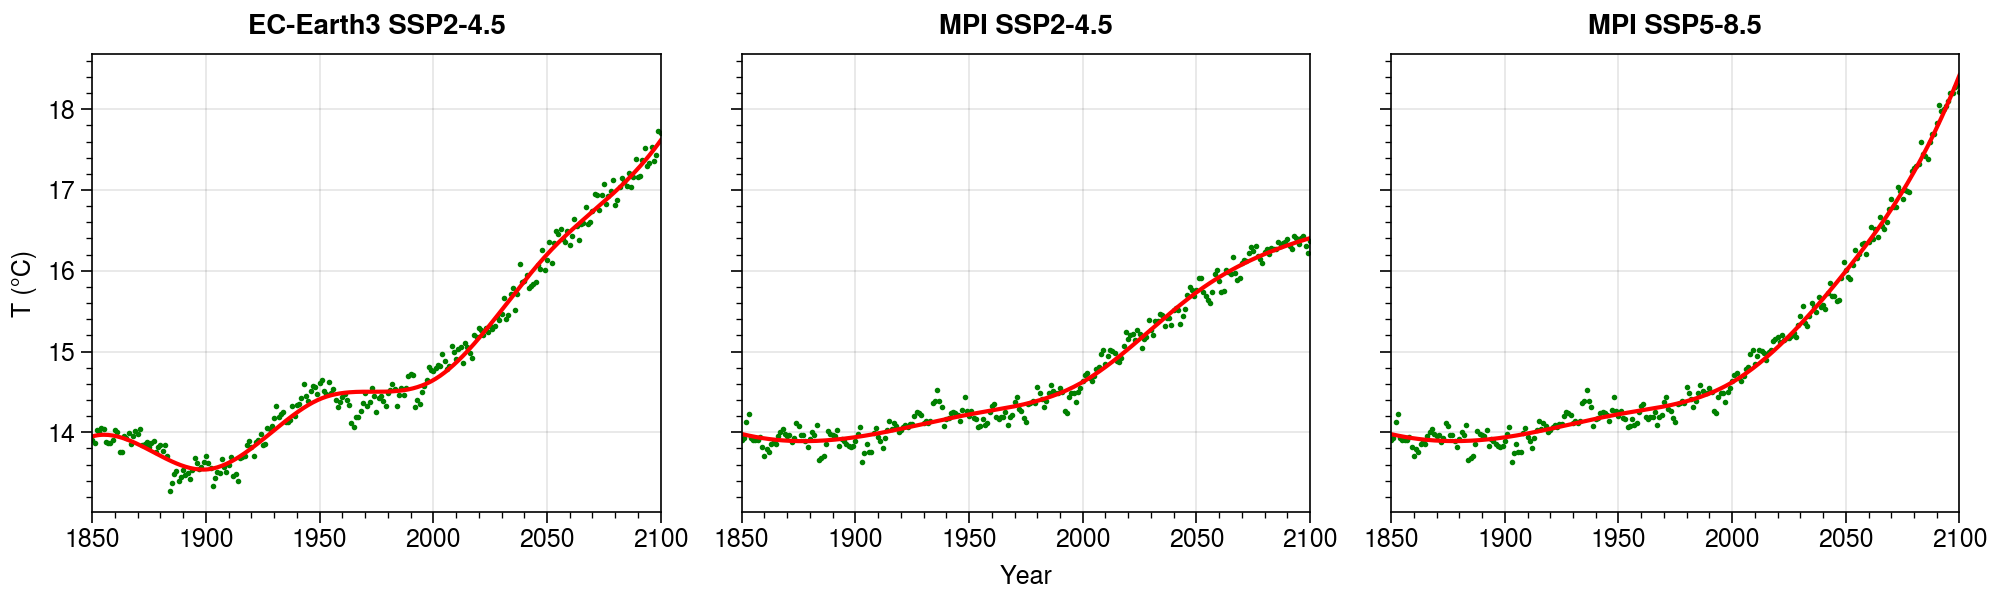

In [30]:
pplt.rc['figure.facecolor'] = 'white'

knots = 4

yrly_tas_list = [yrly_tas_ECEarth_globalmean, yrly_tas_MPI2_globalmean, yrly_tas_MPI5_globalmean]

f, axs = pplt.subplots(ncols=3, figsize=(10, 3))

for col in range(3):
    axs[col].plot(np.arange(1850,2101,1), yrly_tas_list[col], '.',c="g", markersize=2)
    yfit = spline(knots,np.arange(1850,2101,1), yrly_tas_list[col])
    axs[col].plot(np.arange(1850,2101,1), yfit, 'r')


f.format(collabels=['EC-Earth3 SSP2-4.5', 'MPI SSP2-4.5', 'MPI SSP5-8.5'],xlabel='Year',ylabel='T (°C)')

In [24]:
#kn = 4
#yfit = spline(kn,np.arange(1850,2101,1), yrly_tas_ECEarth_globalmean)
#np.save('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_spline_4k.npy', yfit)

#yfit = spline(kn,np.arange(1850,2101,1), yrly_tas_MPI2_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI245_spline_4k.npy', yfit)

#yfit = spline(kn,np.arange(1850,2101,1), yrly_tas_MPI5_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI585_spline_4k.npy', yfit)

In [25]:
splinefit_yrly_ECEarth = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_spline_4k.npy')
splinefit_yrly_MPI245 = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI245_spline_4k.npy')
splinefit_yrly_MPI585 = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI585_spline_4k.npy')

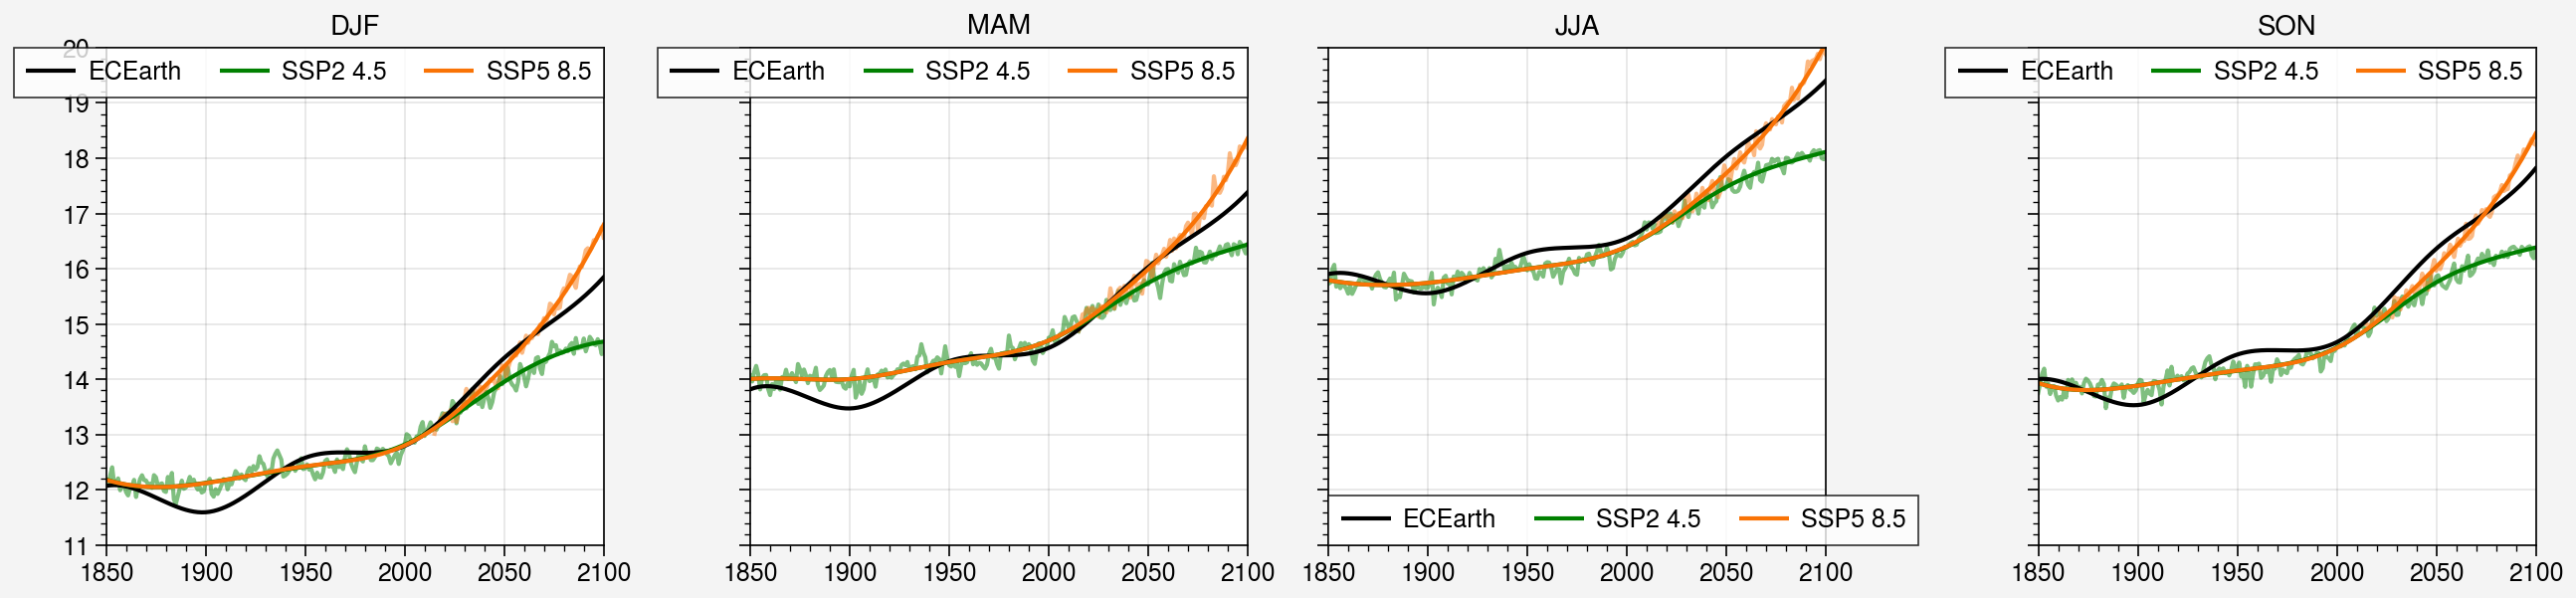

In [31]:
f,axs = pplt.subplots(ncols=4)#,nrows=2)

seasons = ['DJF','MAM','JJA', 'SON']

kn = 4
splinefit_seas_ECEarth = []
splinefit_seas_MPI245 = []
splinefit_seas_MPI585 = []

for seas in range(4):
    ax=axs[seas]

    #ax.plot(np.arange(1850,2015,1),allseas_tas_ECEarth_hist[seas],alpha=0.5,c='k')
    #ax.plot(np.arange(2015,2101,1),allseas_tas_ECEarth_245[seas],alpha=0.5,c='k')
    
    ax.plot(np.arange(1850,2015,1),allseas_tas_MPIhist[seas],alpha=0.5,c='g')
    ax.plot(np.arange(2015,2101,1),allseas_tas_MPI245[seas],alpha=0.5,c='g')
    ax.plot(np.arange(2015,2101,1),allseas_tas_MPI585[seas],alpha=0.5,c='orange')

    splinefit_seas_ECEarth.append(spline(kn,np.arange(1850,2101,1), np.concatenate((allseas_tas_ECEarth_hist[seas],allseas_tas_ECEarth_245[seas]))))
    ax.plot(np.arange(1850,2101,1),splinefit_seas_ECEarth[seas],c='k',label='ECEarth')
    
    splinefit_seas_MPI245.append(spline(kn,np.arange(1850,2101,1), np.concatenate((allseas_tas_MPIhist[seas],allseas_tas_MPI245[seas]))))
    ax.plot(np.arange(1850,2101,1),splinefit_seas_MPI245[seas],c='g',label='SSP2 4.5')

    splinefit_seas_MPI585.append(spline(kn,np.arange(1850,2101,1), np.concatenate((allseas_tas_MPIhist[seas],allseas_tas_MPI585[seas]))))
    ax.plot(np.arange(1850,2101,1),splinefit_seas_MPI585[seas],c='orange',label='SSP5 8.5')
    
    ax.format(title=seasons[seas])
    ax.set_ylim((11.,20))
    ax.legend()


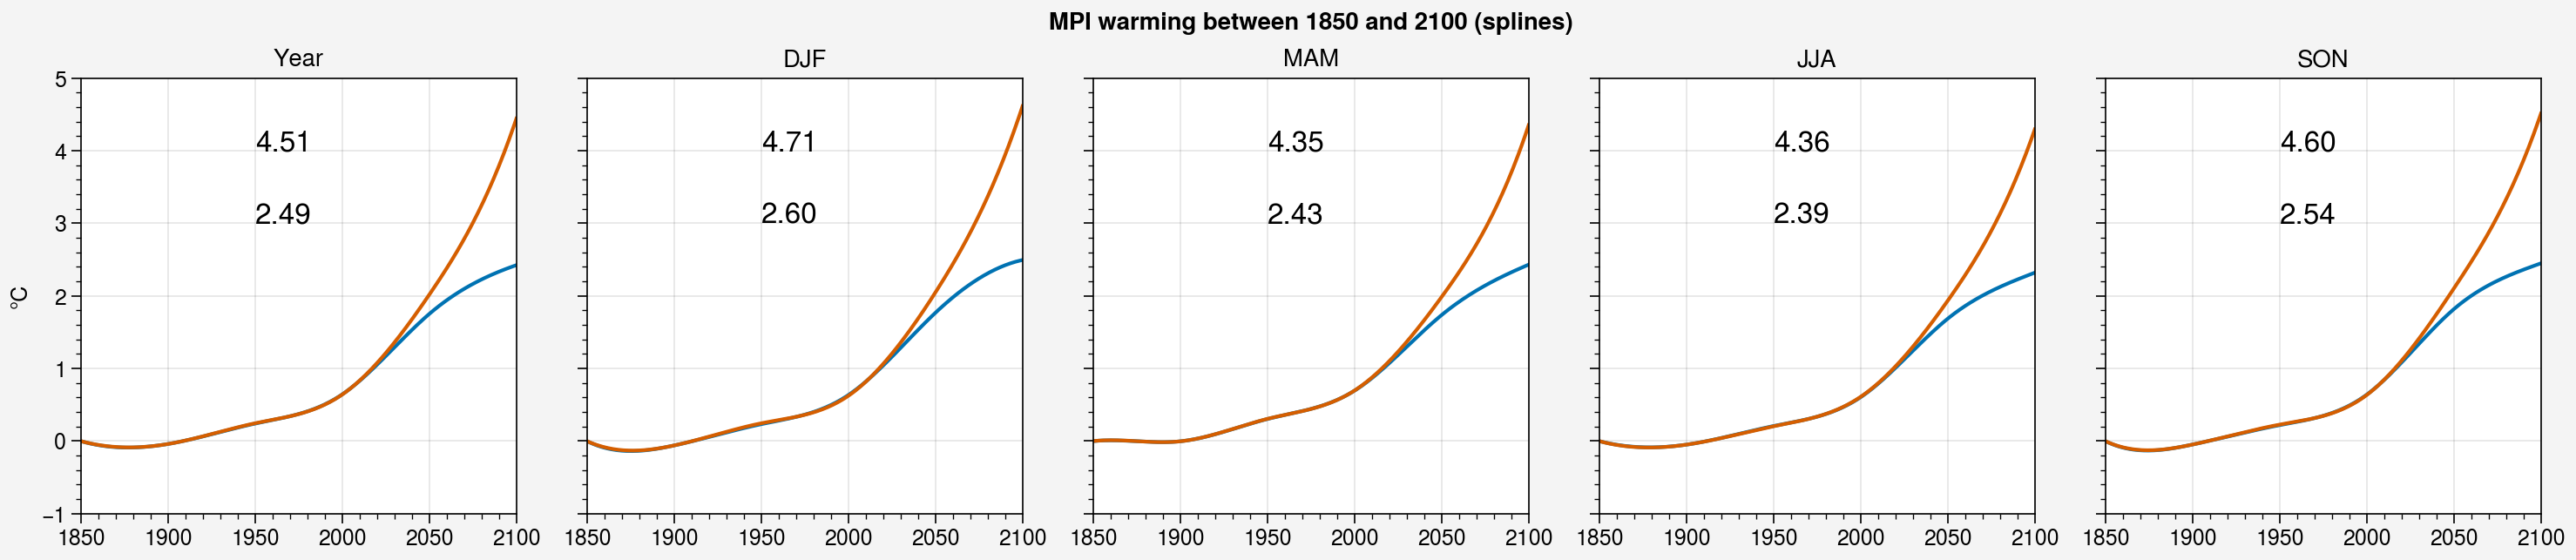

In [32]:
f,axs = pplt.subplots(ncols=5)

splinefit_yrly_MPI245
ax=axs[0]
ax.plot(np.arange(1850,2101,1),splinefit_yrly_MPI245-splinefit_yrly_MPI245[0])
ax.plot(np.arange(1850,2101,1),splinefit_yrly_MPI585-splinefit_yrly_MPI585[0])

#ax.text(1900, 3, "{:.2f}".format(splinefit_yrly_MPI245[-1]-splinefit_yrly_MPI245[0]), fontsize=12)
#ax.text(1900, 4, "{:.2f}".format(splinefit_yrly_MPI585[-1]-splinefit_yrly_MPI585[0]), fontsize=12)

ax.text(1950, 3, "{:.2f}".format(splinefit_yrly_MPI245[-1]-splinefit_yrly_MPI245[0:50].mean()), fontsize=12)
ax.text(1950, 4, "{:.2f}".format(splinefit_yrly_MPI585[-1]-splinefit_yrly_MPI585[0:50].mean()), fontsize=12)

ax.format(title='Year')
ax.set_ylim((-1.,5))

for seas in range(4):
    ax=axs[seas+1]
    ax.plot(np.arange(1850,2101,1),splinefit_seas_MPI245[seas]-splinefit_seas_MPI245[seas][0])
    ax.plot(np.arange(1850,2101,1),splinefit_seas_MPI585[seas]-splinefit_seas_MPI585[seas][0])

    #ax.text(1900, 3, "{:.2f}".format(splinefit_seas_MPI245[seas][-1]-splinefit_seas_MPI245[seas][0]), fontsize=12)
    #ax.text(1900, 4, "{:.2f}".format(splinefit_seas_MPI585[seas][-1]-splinefit_seas_MPI585[seas][0]), fontsize=12)

    ax.text(1950, 3, "{:.2f}".format(splinefit_seas_MPI245[seas][-1]-splinefit_seas_MPI245[seas][0:50].mean()), fontsize=12)
    ax.text(1950, 4, "{:.2f}".format(splinefit_seas_MPI585[seas][-1]-splinefit_seas_MPI585[seas][0:50].mean()), fontsize=12)
    
    ax.format(title=seasons[seas])
    ax.set_ylim((-1.,5))

axs.format(suptitle="MPI warming between 1850 and 2100 (splines)",ylabel='°C')

In [33]:
splinefit_seas_MPI245[seas][-1]

16.383632303203626

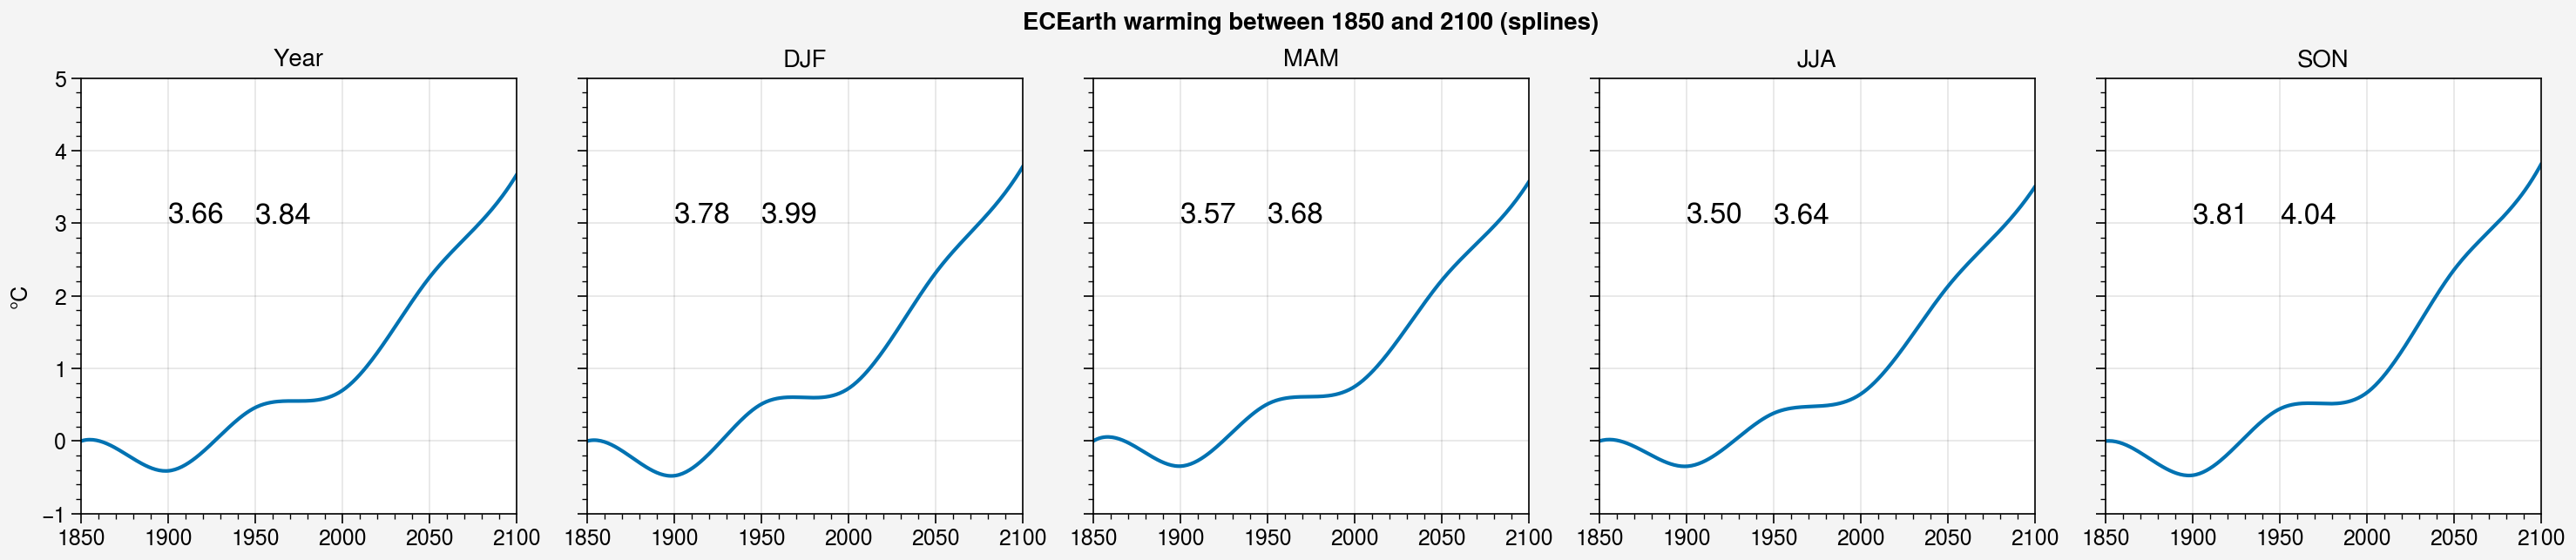

In [34]:
f,axs = pplt.subplots(ncols=5)

ax=axs[0]
ax.plot(np.arange(1850,2101,1),splinefit_yrly_ECEarth-splinefit_yrly_ECEarth[0])

ax.text(1900, 3, "{:.2f}".format(splinefit_yrly_ECEarth[-1]-splinefit_yrly_ECEarth[0]), fontsize=12)
ax.text(1950, 3, "{:.2f}".format(splinefit_yrly_ECEarth[-1]-splinefit_yrly_ECEarth[0:50].mean()), fontsize=12)
    
ax.format(title='Year')
ax.set_ylim((-1.,5))

for seas in range(4):
    ax=axs[seas+1]
    ax.plot(np.arange(1850,2101,1),splinefit_seas_ECEarth[seas]-splinefit_seas_ECEarth[seas][0])

    ax.text(1900, 3, "{:.2f}".format(splinefit_seas_ECEarth[seas][-1]-splinefit_seas_ECEarth[seas][0]), fontsize=12)
    ax.text(1950, 3, "{:.2f}".format(splinefit_seas_ECEarth[seas][-1]-splinefit_seas_ECEarth[seas][0:50].mean()), fontsize=12)
    
    ax.format(title=seasons[seas])
    ax.set_ylim((-1.,5))

axs.format(suptitle="ECEarth warming between 1850 and 2100 (splines)",ylabel='°C')

In [35]:
#np.save('/bettik/castelli/data/EC-Earth3/seas_tas_ECEarth_spline_4k.npy', splinefit_seas_ECEarth)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/seas_tas_MPI245_spline_4k.npy', splinefit_seas_MPI245)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/seas_tas_MPI585_spline_4k.npy', splinefit_seas_MPI585)


### Northern hemisphere warming and continental warming

In [42]:
# NH : Northern Hemisphere
yrly_tas_ECEarth_245_NHmean = u.spatial_average(ds_ECEarth_245.tas.sel(lat = ds_ECEarth_245.lat>=0).groupby("time.year").mean("time")) - 273.16
yrly_tas_ECEarth_hist_NHmean = u.spatial_average(ds_ECEarth_hist.tas.sel(lat = ds_ECEarth_hist.lat>=0).groupby("time.year").mean("time")) - 273.16

yrly_tas_MPIhist_NHmean = u.spatial_average(ds_MPIhist.tas.sel(lat = ds_MPIhist.lat>=0).groupby("time.year").mean("time")) - 273.16
yrly_tas_MPI245_NHmean = u.spatial_average(ds_MPI245.tas.sel(lat = ds_MPI245.lat>=0).groupby("time.year").mean("time")) - 273.16
yrly_tas_MPI585_NHmean = u.spatial_average(ds_MPI585.tas.sel(lat = ds_MPI585.lat>=0).groupby("time.year").mean("time")) - 273.16


In [44]:
#kn = 4
#yfit = spline(kn,np.arange(1850,2101,1), np.concatenate([yrly_tas_ECEarth_hist_NHmean,yrly_tas_ECEarth_245_NHmean]))
#np.save('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_spline_4k_NHmean.npy', yfit)

#yfit = spline(kn,np.arange(1850,2101,1), np.concatenate([yrly_tas_MPIhist_NHmean,yrly_tas_MPI245_NHmean]))
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI245_spline_4k_NHmean.npy', yfit)

#yfit = spline(kn,np.arange(1850,2101,1), np.concatenate([yrly_tas_MPIhist_NHmean,yrly_tas_MPI585_NHmean]))
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI585_spline_4k_NHmean.npy', yfit)

In [45]:
splinefit_yrly_ECEarth_NHmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_spline_4k_NHmean.npy')
splinefit_yrly_MPI245_NHmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI245_spline_4k_NHmean.npy')
splinefit_yrly_MPI585_NHmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI585_spline_4k_NHmean.npy')